In [34]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from datetime import datetime, timedelta

#### Задача 1: написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

Считываем данные:

In [35]:
reg_data = pd.read_csv('data/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('data/problem1-auth_data.csv', sep=';')

In [36]:
reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [37]:
auth_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


Как мы видим, дата и время в наших данных хранятся в timestamp. Переведем их в привычный для нас вид:

In [38]:
reg_data.reg_ts   =   reg_data.reg_ts.apply(lambda x: datetime.fromtimestamp(x))
auth_data.auth_ts = auth_data.auth_ts.apply(lambda x: datetime.fromtimestamp(x))

reg_data  =  reg_data.rename(columns={'reg_ts': 'date'})
auth_data = auth_data.rename(columns={'auth_ts': 'date'})

reg_data.set_index(reg_data.date, inplace=True)
auth_data.set_index(auth_data.date, inplace=True)

In [39]:
reg_data = reg_data.drop('date', axis=1)
auth_data = auth_data.drop('date', axis=1)

In [40]:
reg_data.head(3)

,uid
date,
1998-11-18 15:43:43,1
1999-07-23 05:38:09,2
2000-01-14 04:27:27,3


In [41]:
auth_data.head(3)

,uid
date,
1998-11-18 15:43:43,1
1999-07-23 05:38:09,2
1999-07-25 23:46:46,2


In [42]:
reg_data = reg_data.resample(rule='D').apply(set)

In [43]:
auth_data = auth_data.resample(rule='D').apply(set)

Напишем функцию для подсчета retention rate:

In [44]:
def retention_rate(reg_date, 
                   auth_date) -> float:
    """
    Подсчет retention rate в день auth_date для пользователей, установивших в день reg_date
    
    Parameters
    ----------
    reg_date: интересующая дата регистрации в формате "yyyy-mm-dd" или в Timestamp
    auth_date: интересующая дата входа в формате "yyyy-mm-dd" или в Timestamp
    
    Returns
    -------
    retention_rate: float retention_rate в процентах
    """
    
    if type(reg_date) == 'str':
        reg_date  = datetime.strptime(reg_date, "%Y-%m-%d")
    if type(auth_date) == 'str':
        auth_date = datetime.strptime(auth_date, "%Y-%m-%d")
    
    reg_ids  = reg_data.loc[reg_date].uid
    auth_ids = auth_data.loc[auth_date].uid
    
    if len(reg_ids) != 0:
        retention_rate = len(reg_ids & auth_ids) / len(reg_ids) * 100
    else:
        retention_rate = 0
    
    return retention_rate

In [45]:
retention_rate('2020-09-21', '2020-09-23')

3.6019536019536016

In [46]:
def retention_for_all_data(x=14):
    """
    Подсчет retention rate в день auth_date для пользователей, установивших в день reg_date
    
    Parameters
    ----------
    x: int
       интервал подсчета retention в днях
    
    Returns
    -------
    retentions: pd.Series
                retention rates
    dates: pd.Series
           на какие даты считаем retention
    """

    retentions = []
    dates = []
    for i in reg_data.index:
        auth_date = i + timedelta(days=x)
        if auth_date > auth_data.index.max():
            break
        retention = retention_rate(i, auth_date)
        retentions.append(retention)
        dates.append(auth_date)
        
    return pd.Series(retentions), pd.Series(dates)

In [47]:
def visualize_retention(retentions, dates, window=365):
    """
    Визуализация retention за все время
    
    Parameters
    ----------
    retentions: pd.Series
                retention rates
    dates: pd.Series
           на какие даты считаем retention
    
    Returns
    -------
    fig: plotly.graph_objects.Figure
         график
    """
    fig = go.Figure(layout_title_text=f"Retention Rate with rolling window = {window} days")
    rolling_mean_retention = retentions.rolling(window).mean()
    fig.add_trace(go.Scatter(x=dates, y=rolling_mean_retention,
                        mode='lines'))
    fig.show()

In [57]:
retentions, dates = retention_for_all_data(30)

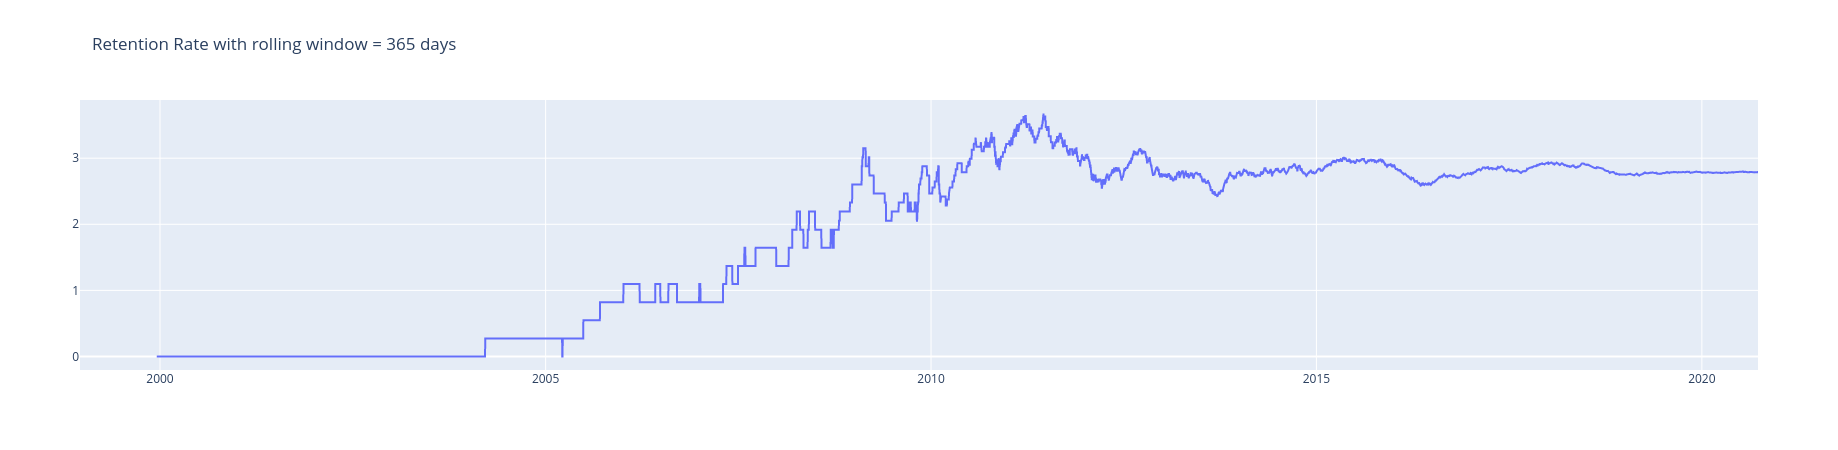

In [58]:
visualize_retention(retentions, dates, window=365)

#### Задача 2: 